In [1]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
#from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K



In [3]:
from tqdm import tqdm
import os
import pandas as pd
images = []
labels = []
for subfolder in tqdm(os.listdir(r"C:\Users\Sreek\Dropbox\PC\Downloads\archive(12)\Alzheimer_s Dataset")):
    subfolder_path = os.path.join(r"C:\Users\Sreek\Dropbox\PC\Downloads\archive(12)\Alzheimer_s Dataset", subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            images.append(image_path)
            labels.append(folder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 30.99it/s]


image             label
0     C:\Users\Sreek\Dropbox\PC\Downloads\archive(12...      MildDemented
1     C:\Users\Sreek\Dropbox\PC\Downloads\archive(12...      MildDemented
2     C:\Users\Sreek\Dropbox\PC\Downloads\archive(12...      MildDemented
3     C:\Users\Sreek\Dropbox\PC\Downloads\archive(12...      MildDemented
4     C:\Users\Sreek\Dropbox\PC\Downloads\archive(12...      MildDemented
...                                                 ...               ...
6395  C:\Users\Sreek\Dropbox\PC\Downloads\archive(12...  VeryMildDemented
6396  C:\Users\Sreek\Dropbox\PC\Downloads\archive(12...  VeryMildDemented
6397  C:\Users\Sreek\Dropbox\PC\Downloads\archive(12...  VeryMildDemented
6398  C:\Users\Sreek\Dropbox\PC\Downloads\archive(12...  VeryMildDemented
6399  C:\Users\Sreek\Dropbox\PC\Downloads\archive(12...  VeryMildDemented

[6400 rows x 2 columns]

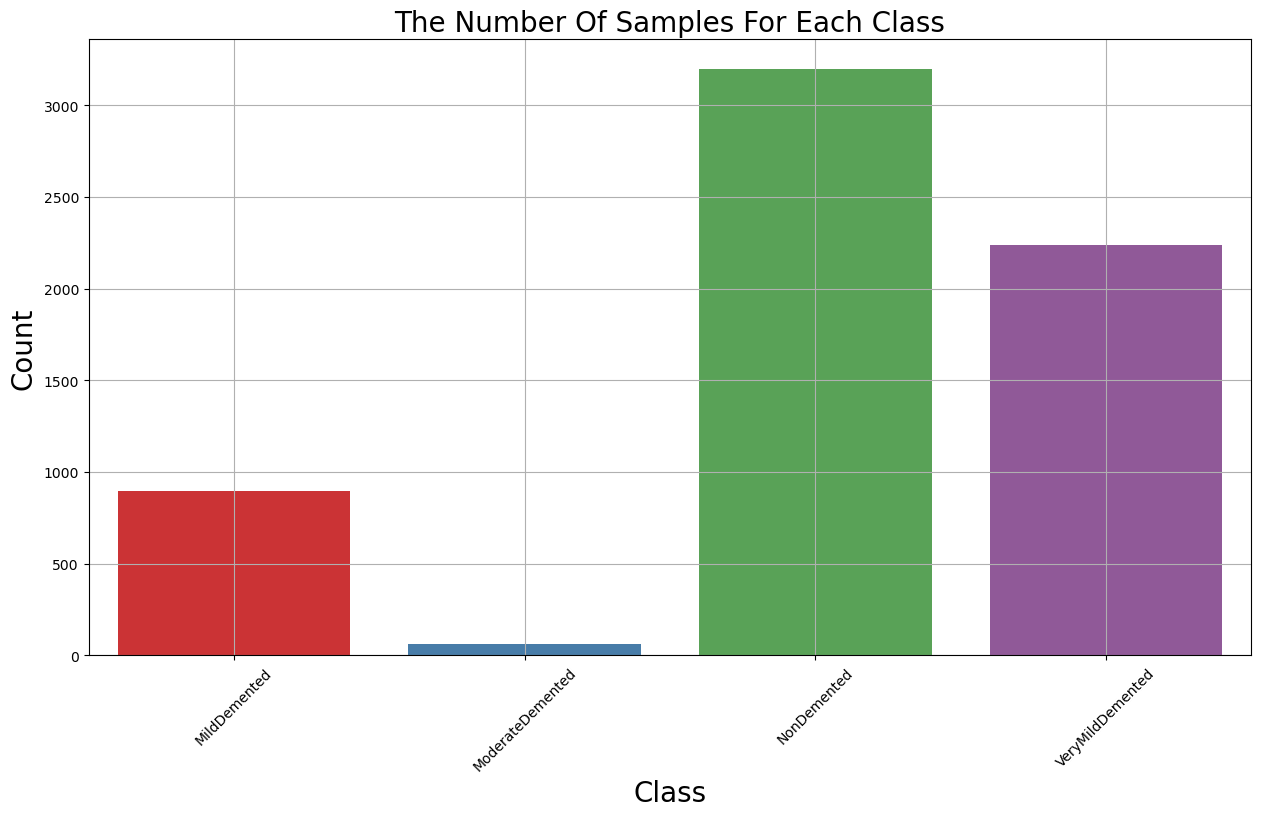

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
ax = sns.countplot(x=df.label,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

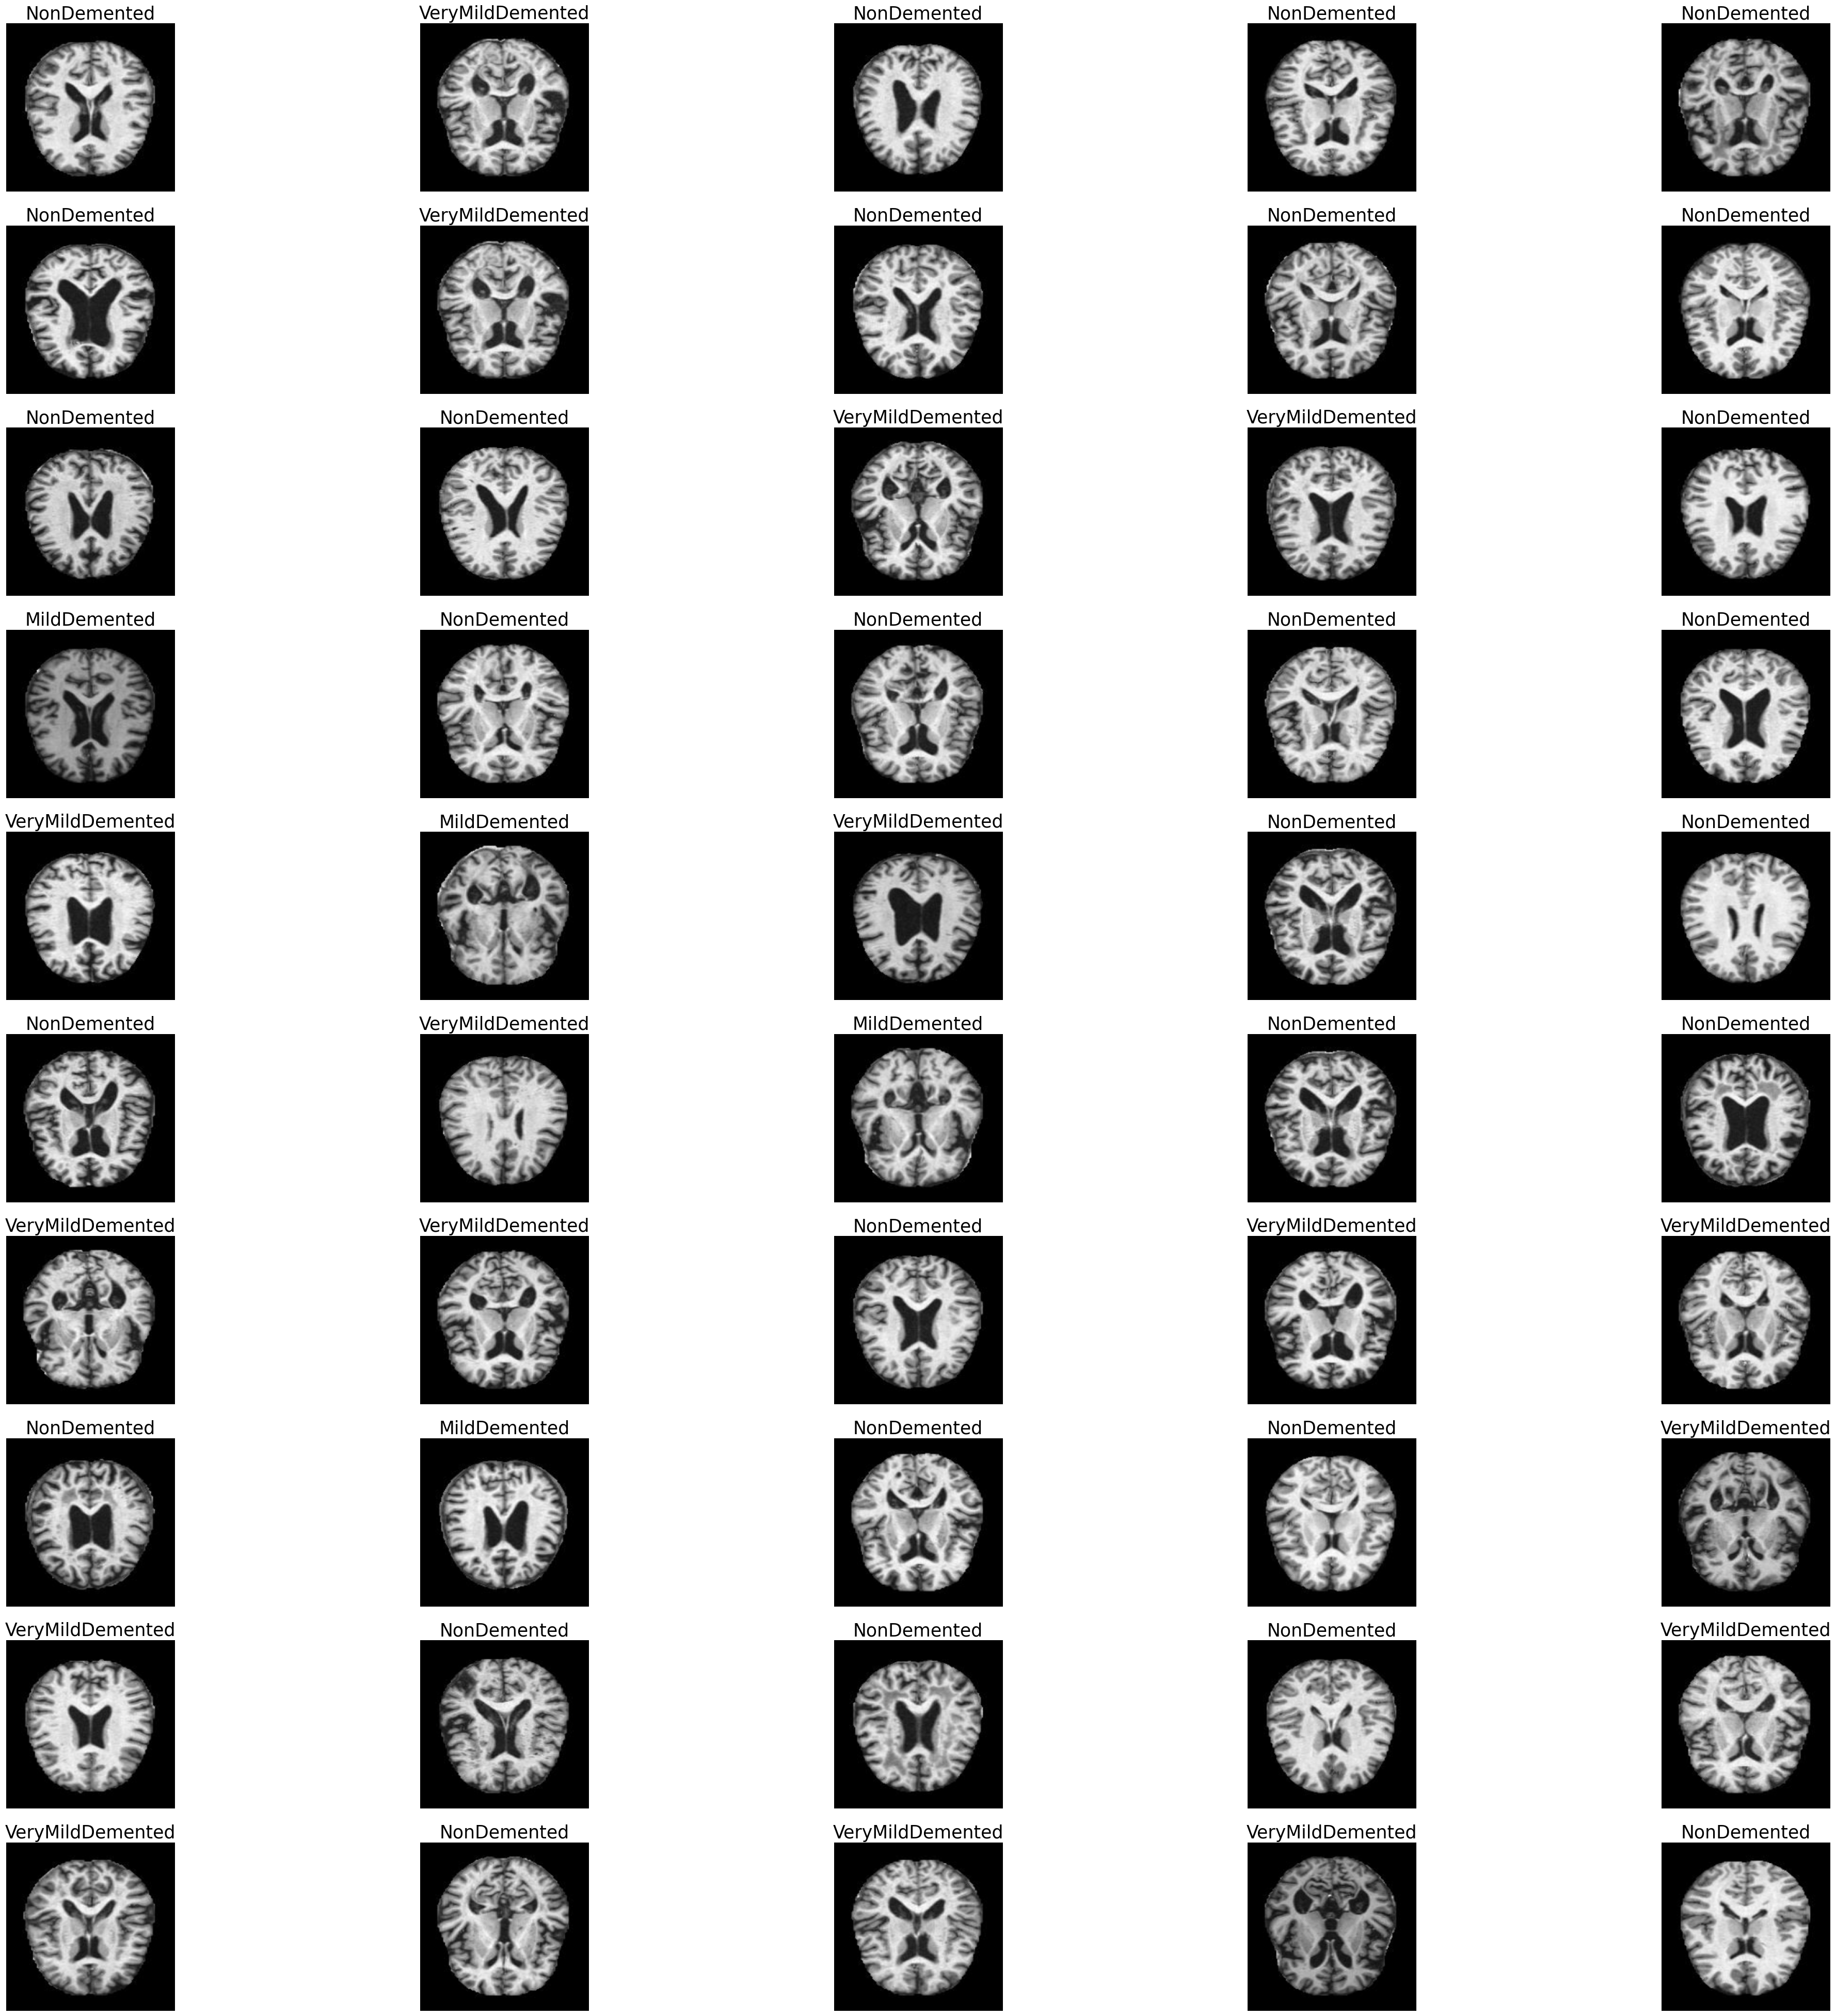

In [9]:
import numpy as np
import cv2

plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

In [77]:
train_data_gen.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
Size=(176,176)
work_dr = ImageDataGenerator(
    rescale = 1./255
)
train_data_gen = work_dr.flow_from_dataframe(df,x_col='image',y_col='label', target_size=Size, batch_size=6500, shuffle=False)

Found 6400 validated image filenames belonging to 4 classes.


In [12]:
for i in range(len(train_data_gen)):
    train_data, train_labels = train_data_gen[i]

In [13]:
class_num=np.sort(['MildDemented','ModerateDemented','NonDemented','VeryMildDemented'])
class_num

array(['MildDemented', 'ModerateDemented', 'NonDemented',
       'VeryMildDemented'], dtype='<U16')

In [15]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
train_data = train_data.reshape(-1, 176,176, 3)
print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


C:\Users\Sreek\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


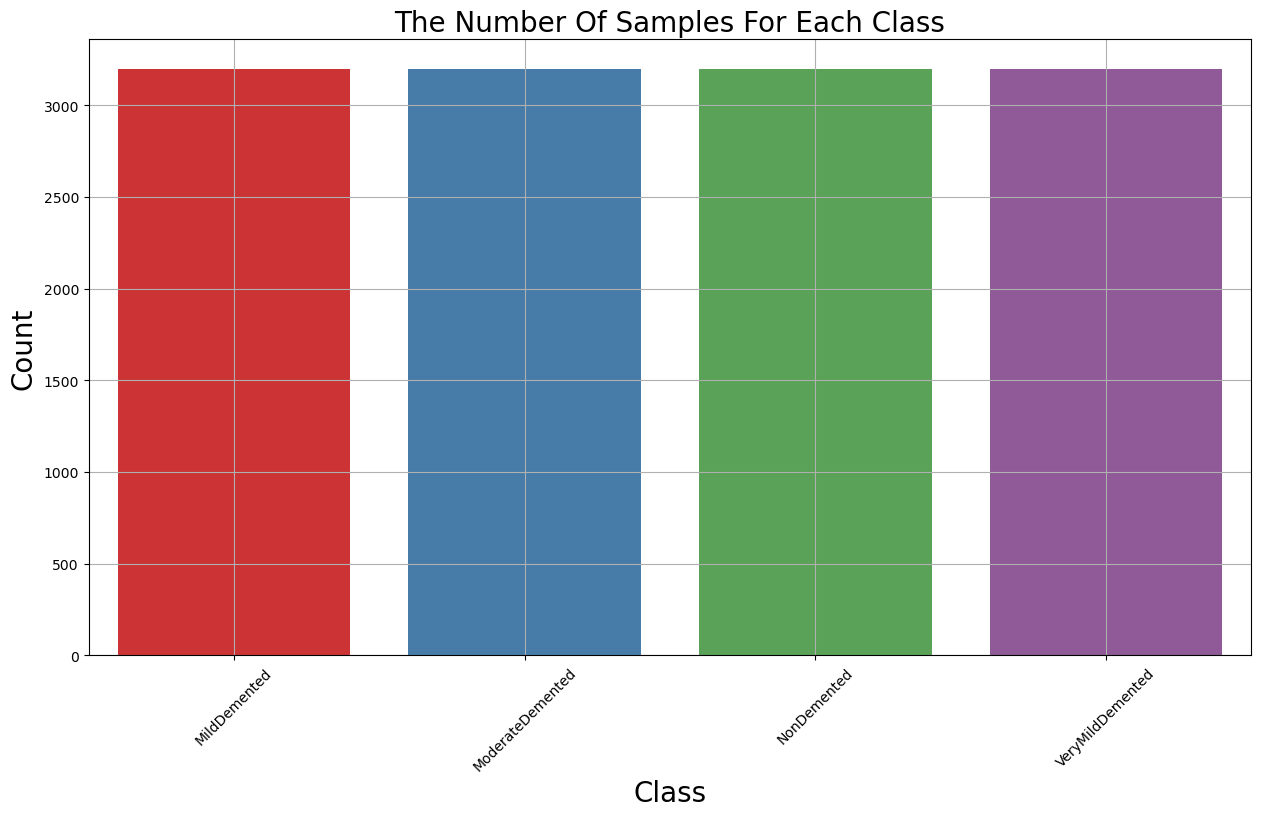

In [16]:
labels=[class_num[i] for i in np.argmax(train_labels,axis=1) ]
plt.figure(figsize=(15,8))
ax = sns.countplot(x=labels,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test1, y_train, y_test1 = train_test_split(train_data,train_labels, test_size=0.3, random_state=42,shuffle=True,stratify=train_labels)
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('X_val shape is ' , X_val.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)
print('y_val shape is ' , y_val.shape)

X_train shape is  (8960, 176, 176, 3)
X_test shape is  (1920, 176, 176, 3)
X_val shape is  (1920, 176, 176, 3)
y_train shape is  (8960, 4)
y_test shape is  (1920, 4)
y_val shape is  (1920, 4)


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input

class_num = 4
input_shape = (176, 176, 3)
base_model = ResNet50(include_top=False, weights="imagenet", input_tensor=Input(shape=input_shape))

for layer in base_model.layers:
    layer.trainable = False

# Building Model
model = tf.keras.Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(class_num, activation='softmax'))
model.build((None,) + input_shape)
ResNet = model
ResNet.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 6, 6, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 6, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 73728)               │         294,912 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       4,718,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 32)                  │              

 Total params: 28,613,892 (109.15 MB)

 Trainable params: 4,878,212 (18.61 MB)

 Non-trainable params: 23,735,680 (90.54 MB)

In [23]:
checkpoint_cb =ModelCheckpoint("ResNet.keras", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=10, restore_best_weights=True)
ResNet.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = ResNet.fit(X_train,y_train, epochs=100, validation_data=(X_val,y_val), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 258s 880ms/step - accuracy: 0.2886 - loss: 1.4606 - val_accuracy: 0.4266 - val_loss: 1.2333
Epoch 2/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 236s 843ms/step - accuracy: 0.4235 - loss: 1.1628 - val_accuracy: 0.4849 - val_loss: 0.9347
Epoch 3/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 232s 830ms/step - accuracy: 0.4738 - loss: 0.9961 - val_accuracy: 0.4995 - val_loss: 0.8747
Epoch 4/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 231s 824ms/step - accuracy: 0.4886 - loss: 0.9556 - val_accuracy: 0.4953 - val_loss: 0.8600
Epoch 5/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 230s 823ms/step - accuracy: 0.4872 - loss: 0.9428 - val_accuracy: 0.4979 - val_loss: 0.8548
Epoch 6/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 231s 826ms/step - accuracy: 0.4867 - loss: 0.9365 - val_accuracy: 0.6042 - val_loss: 0.8401
Epoch 7/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 233s 831ms/step - accuracy: 0.4840 - loss: 0.9159 - val_accuracy: 0.5000 - val_loss: 0.8427
Epoch 8/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 230s 821ms/step - accuracy: 

In [58]:
hist_=pd.DataFrame(hist.history)
hist_

accuracy      loss  val_accuracy  val_loss
0   0.305915  1.397505      0.426562  1.233304
1   0.448549  1.099852      0.484896  0.934722
2   0.478348  0.978716      0.499479  0.874724
3   0.488839  0.956653      0.495313  0.859955
4   0.482701  0.935365      0.497917  0.854785
..       ...       ...           ...       ...
95  0.855357  0.383143      0.924479  0.220773
96  0.861830  0.376606      0.925000  0.216499
97  0.857366  0.384628      0.929167  0.215972
98  0.856473  0.373150      0.923958  0.218704
99  0.861049  0.377662      0.933854  0.213905

[100 rows x 4 columns]

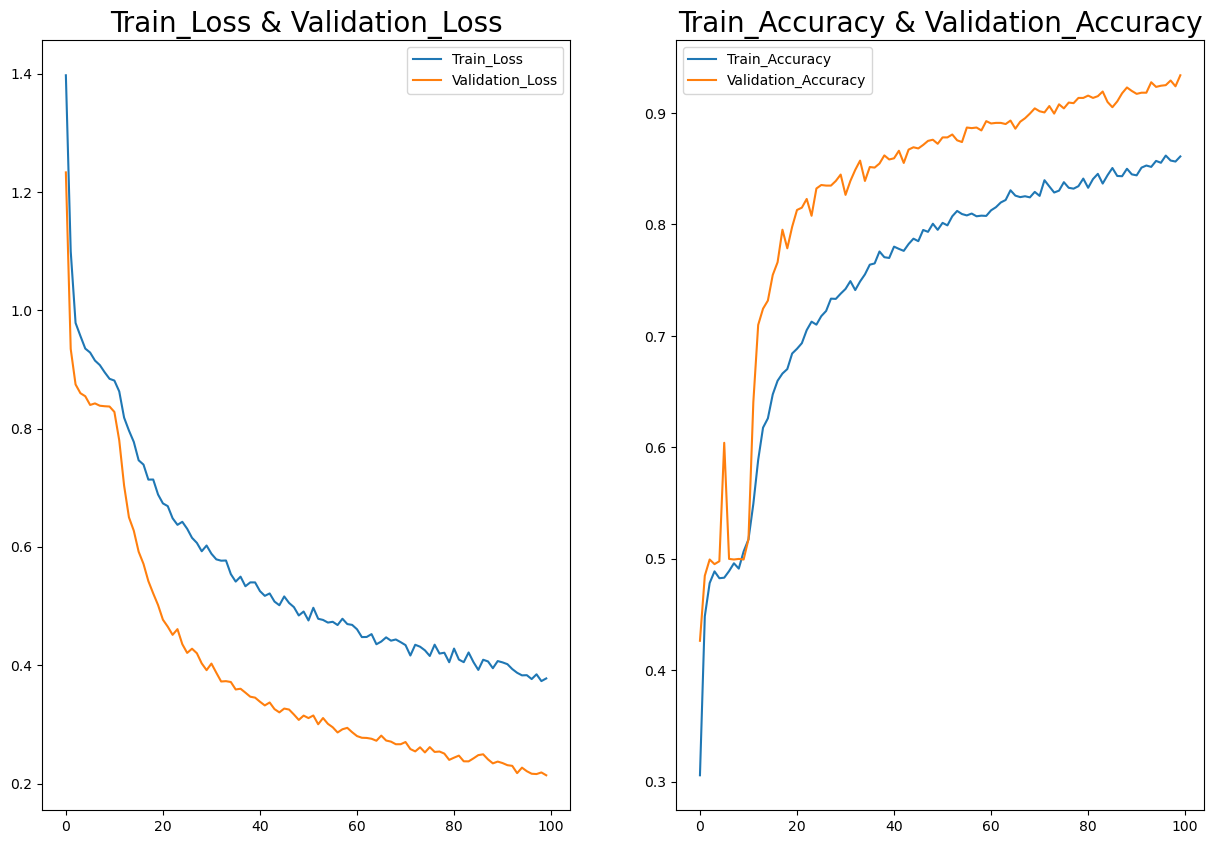

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [62]:
ClassificationReport = classification_report(y_test_,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.99      1.00      0.99       480
           1       1.00      1.00      1.00       480
           2       0.93      0.83      0.88       480
           3       0.85      0.93      0.89       480

    accuracy                           0.94      1920
   macro avg       0.94      0.94      0.94      1920
weighted avg       0.94      0.94      0.94      1920



In [66]:
ResNet.save('resnet_50.h5', save_format='h5')  # Ensure the format is explicitly set if needed

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

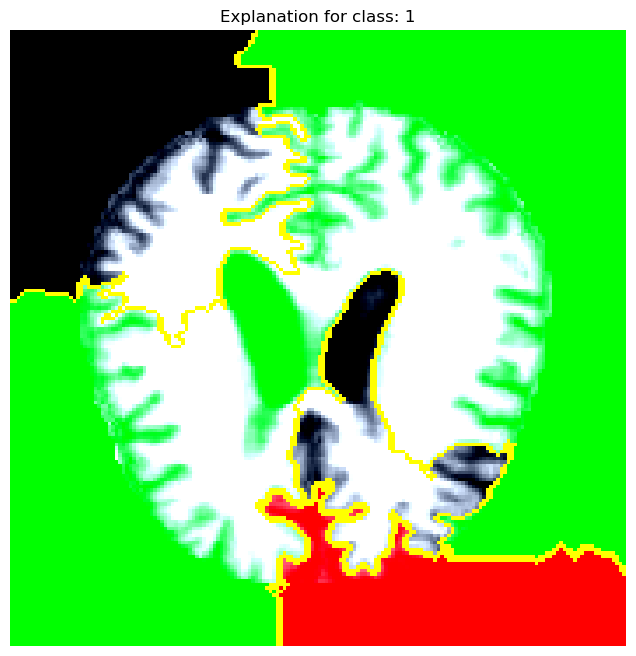

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import load_model
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

def preprocess_image(img_path, target_size=(176, 176)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array_expanded_dims)

image_path = r"C:\Users\Sreek\Dropbox\PC\Downloads\archive(12)\Alzheimer_s Dataset\test\ModerateDemented\27.jpg"

preprocessed_img = preprocess_image(image_path)

model = load_model('resnet_50.h5')

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(preprocessed_img[0].astype('double'), 
                                         model.predict, top_labels=5, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title(f'Explanation for class: {explanation.top_labels[0]}')
plt.axis('off')  # Hide the axes
plt.show()